In [23]:
#!pip install spacy
#!pip install webdriver_manager
# !pip install pickle

In [24]:
from spacy.cli import download

download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import glob
import pickle
import re
import string
from typing import List
from typing import Union, Dict
from urllib.parse import unquote, quote_plus

from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
import numpy as np
import spacy
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import time

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [27]:
electronic_household_items = [
    "television", "iron", "vacuum cleaner", "blender", "microwave", "toaster", "coffee maker",
    "dishwasher", "refrigerator", "oven", "washer", "dryer", "air conditioner", "heater", "fan",
    "hair dryer", "electric kettle", "rice cooker", "slow cooker", "pressure cooker", "food processor",
    "mixer", "juicer", "grill", "waffle maker", "sandwich maker", "popcorn maker", "ice cream maker",
    "electric griddle", "hot plate", "water purifier", "humidifier", "dehumidifier", "air purifier",
    "ceiling fan", "space heater", "robot vacuum", "cordless drill", "security camera", "smart doorbell",
    "smart lock", "thermostat", "smart light switch", "smart plug", "smart speaker", "sound bar",
    "home theater system", "streaming device", "gaming console", "router", "smart TV", "wireless charger",
    "Bluetooth speaker", "tablet", "e-reader", "smartphone", "smartwatch", "fitness tracker", "laptop",
    "desktop computer", "monitor", "keyboard", "mouse", "external hard drive", "USB flash drive",
    "headphones", "earbuds", "webcam", "digital camera", "camcorder", "drone", "smart light bulb",
    "electric toothbrush", "electric shaver", "hair straightener", "hair curler", "foot massager",
    "electric blanket", "electric skillet", "bread maker", "sous vide cooker", "food dehydrator",
    "electric wine opener", "electric can opener", "electric knife", "electric pressure washer",
    "smart refrigerator", "smart oven", "smart microwave", "robot lawn mower", "video doorbell",
    "smart garage door opener", "smart blinds", "smart irrigation system", "smart smoke detector",
    "smart carbon monoxide detector", "smart thermostat", "smart security system", "home automation hub",
    "smart scale", "robot mop", "smart ceiling fan", "smart alarm clock"
]

In [28]:
class Product:
    def __init__(self, product_id, name, category, price, description, about, brand, rating, image_url):
        self.product_id = product_id
        self.name = name
        self.price = price
        self.category = category
        self.description = description
        self.about = about
        self.brand = brand
        self.rating = rating
        self.image_url = image_url
        self.reviews = []

    def add_review(self, review):
        self.reviews.append(review)


In [29]:
class Review:
    def __init__(self, text: str):
        self.text: str = text

In [30]:
class ReviewScrapper:
    def __init__(self):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def fetch_reviews(self, product_link):
        self.driver.get(product_link)
        time.sleep(5)
        reviews = []

        try:
            self.driver.find_element(By.PARTIAL_LINK_TEXT, "See more reviews").click()
            time.sleep(5)

            # Fetch reviews from the next page
            html_content = self.driver.page_source
            reviews.extend(self.parse_review_page(html_content))

            # Check for the next page link and click it
            next_page = self.driver.find_elements(By.CSS_SELECTOR, "li.a-last a")
            if next_page:
                next_page[0].click()
                time.sleep(5)  # Wait for the next page to load

                # Fetch reviews from the next page
                html_content = self.driver.page_source
                reviews.extend(self.parse_review_page(html_content))

        except Exception as e:
            print(f"Error fetching reviews: {e}")
        finally:
            self.cleanup()
        return reviews

    def parse_review_page(self, html_content):
        soup = BeautifulSoup(html_content, 'html.parser')
        review_texts = [tag.get_text(strip=True) for tag in soup.find_all('span', {'data-hook': 'review-body'})]
        return [Review(text) for text in review_texts]

    def cleanup(self):
        self.driver.quit()


In [31]:
class Scrapper:
    def __init__(self):
        self.keyword: Union[str | None] = None
        self.product_count: int = 11
        self.base_url: str = "https://www.amazon.ca"
        self.products: List[Product] = []
        self.skipped_categories: List[str] = []
        self.max_retries: int = 1
        # self.categories: List[str] = electronic_household_items
        self.categories: List[str] = [
            # "smart TV", 12-
            # "Bluetooth speaker",
            # "tablet",
            # "e-reader", "smartphone", "smartwatch", "fitness tracker", "laptop",
            # "desktop computer", "monitor", "keyboard", "mouse", "external hard drive", "USB flash drive",
            # "smart plug", "smart speaker", "sound bar",
        ]

        self.headers: Dict[str, str] = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            'Accept-Language': 'en-US, en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Referer': 'https://www.google.com/',
        }

        # Initialize Selenium WebDriver
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(options=options)

    def set_keyword(self, keyword: str):
        self.keyword = keyword

    def search_products(self):
        search_url = f"{self.base_url}/s?k={quote_plus(self.keyword)}"

        for _ in range(self.max_retries):
            try:
                response = requests.get(search_url, headers=self.headers)
                response.raise_for_status()
                print(search_url, response.status_code)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.content, 'html.parser')
                    product_links = [
                        self.base_url + tag['href']
                        for tag in soup.find_all('a', {'class': 'a-link-normal s-no-outline'}, href=True)
                    ]

                    print(f"Found {len(product_links)} products")
                    return product_links[10:self.product_count]
                else:
                    print(f"Failed to fetch the search results. Status code: {response.status_code}")
            except requests.exceptions.RequestException as e:
                print(f"Exception Error fetching search results: {e}")
            except Exception as e:
                print(f"Error fetching search results: {e}")

            # Wait before retrying
            time.sleep(5)
            # If all retries fail, add the keyword to skipped categories
        self.skipped_categories.append(self.keyword)
        return []

    def extract_product_details(self, product_link: str):
        response = requests.get(product_link, headers=self.headers)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            try:
                category = self.keyword

                # Decode the URL to handle escaped characters
                decoded_url = unquote(product_link)

                # Regular expression pattern to match the ASIN in the URL
                asin_pattern = r'/dp/([A-Z0-9]{10})/'
                asin_match = re.search(asin_pattern, decoded_url)

                # Return the matched ASIN or None if no match is found
                product_id = asin_match.group(1) if asin_match else None
                print(product_id)

                name = soup.find(id="productTitle").get_text(strip=True)
                name = name.strip() if name else None

                brand = soup.select_one('tr.po-brand')
                brand = brand.get_text(strip=True).replace('Brand', '') if brand else None

                if brand is None:
                    brand = soup.select_one('a#bylineInfo')
                    brand = brand.get_text(strip=True).replace('Brand:', '') if brand else None

                # scrape product price
                price = soup.select_one('span.a-offscreen')
                price = price.text.replace('$', '') if price else None

                if not price:
                    price_whole = soup.select_one('span.a-price-whole').get_text(strip=True)
                    price_decimal = soup.select_one('span.a-price-fraction').get_text(strip=True)
                    price = f'{price_whole}.{price_decimal}'

                about = soup.find(id="feature-bullets").get_text(strip=True)
                about = about.strip() if about else None

                description = soup.select_one('#productDescription')
                description = description.text.strip() if description else None

                image_url = soup.find("img", {"id": "landingImage"})
                image_url = image_url['src'] if image_url else None

                # scrape product rating
                rating_element = soup.select_one('#acrPopover').attrs.get('title')
                rating = rating_element.replace('out of 5 stars', '') if rating_element else None

                return Product(
                    product_id=product_id,
                    name=name,
                    category=category,
                    price=price,
                    description=description,
                    about=about,
                    brand=brand,
                    rating=rating,
                    image_url=image_url
                )
            except AttributeError:
                print("Error parsing product details.")
                return None
        else:
            print("Failed to fetch the product page.")
            return None

    def aggregate_data(self):
        product_links = self.search_products()

        for link in product_links:
            product = self.extract_product_details(link)

            if product:
                self.products.append(product)
                review_scraper = ReviewScrapper()
                reviews = review_scraper.fetch_reviews(link)

                for review in reviews:
                    product.add_review(review)

    def save_to_csv(self, file_name: str):
        data = []
        columns = ['Id', 'Name', 'Category', 'Price', 'Description', 'About', 'Rating', 'ImageUrl', 'Brand', 'Review']

        if len(self.products) == 0:
            return

        for product in self.products:
            for review in product.reviews:
                data.append({
                    'Id': product.product_id,
                    'Name': product.name,
                    'Category': product.category,
                    'Price': product.price,
                    'Description': product.description,
                    'About': product.about,
                    'Rating': product.rating,
                    'ImageUrl': product.image_url,
                    'Brand': product.brand,
                    'Review': review.text,
                })

        df = pd.DataFrame(data, columns=columns)
        df.to_csv(file_name, index=False)

        # reset the current data
        self.products = []

        print(f"Data saved to {file_name}")

    def merge_csv(self):
        csv_files = glob.glob('./data/*.{}'.format('csv'))

        if len(csv_files) == 0:
            return

        dataset = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        dataset.to_csv('amazon_electronics_products_reviews.csv', index=False)

        print(f"Data saved and merged.")

    def cleanup(self):
        self.driver.quit()

    def run(self):
        for category in self.categories:
            name = category.replace(' ', '_')
            file_name = f'./data/amazon_{name}_products_reviews.csv'
            self.set_keyword(category)
            self.aggregate_data()
            self.save_to_csv(file_name)

            time.sleep(5)

        self.cleanup()
        print(f'Skipped categories are: {self.skipped_categories}')
        self.merge_csv()


if __name__ == "__main__":
    scraper = Scrapper()
    scraper.run()



Skipped categories are: []
Data saved and merged.


In [3]:
class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        self.spacy_en = spacy.load('en_core_web_sm')
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)  # Remove HTML tags
        text = re.sub('[^A-Za-z0-9]+', ' ', text)  # Remove special characters
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def lemmatizer(self, text: str) -> str:
        #  the text using spaCy
        text = self.spacy_en(text)

        # get the lemmatized token from text
        lemmatized_tokens = [token.lemma_ for token in text]

        # use lemmatized token to form a sentence
        return ' '.join(lemmatized_tokens)

    def init_bag_of_words(self, end_range: int):
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate_from_frequencies(
            data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


In [4]:
# Example usage
text = "This is a sample text with goooood words and some stopwords. It also has digits like 123 and punctuations!"

tw = TextWrangler()
text_without_digits = tw.remove_digit(text)
print("Text without digits:", text_without_digits)

text_without_punctuations = tw.remove_punctuations(text)
print("Text without punctuations:", text_without_punctuations)

fixed_text = tw.word_lengthening("Goooood")
print("Fixed word:", fixed_text)

filtered_text = tw.remove_stopwords(text)
print("Text without stop words:", filtered_text)

tokens = tw.tokenize(text)
print("Tokens:", tokens)

texts = ["This is the first document.", "This document is the second document.", "And this is the third one."]
tfidf_matrix = tw.tf_idf(texts)
print("TF-IDF matrix:", tfidf_matrix.toarray())

tfidf_matrix_3 = tw.tf_idf(texts)
print("TF-IDF matrix:", tfidf_matrix_3.toarray())
print("TF-IDF matrix:", tw.tf_idf_.vocabulary_)

bow_matrix = tw.bag_of_words(texts)
print("Bag of Words matrix:", bow_matrix.toarray())
print("BOW:", tw.count.vocabulary_)

bow_matrix_3 = tw.init_bag_of_words(3)
bow_matrix_3 = tw.bag_of_words(texts)

print("Bag of Words matrix:", bow_matrix_3.toarray())

Text without digits: This is a sample text with goooood words and some stopwords. It also has digits like  and punctuations!
Text without punctuations: This is a sample text with goooood words and some stopwords It also has digits like 123 and punctuations
Fixed word: Good
Text without stop words: sample text goooood words stopwords . also digits like 123 punctuations !
Tokens: ['This', 'is', 'a', 'sample', 'text', 'with', 'goooood', 'words', 'and', 'some', 'stopwords', '.', 'It', 'also', 'has', 'digits', 'like', '123', 'and', 'punctuations', '!']
TF-IDF matrix: [[0.         0.46941728 0.61722732 0.3645444  0.         0.
  0.3645444  0.         0.3645444 ]
 [0.         0.7284449  0.         0.28285122 0.         0.47890875
  0.28285122 0.         0.28285122]
 [0.49711994 0.         0.         0.29360705 0.49711994 0.
  0.29360705 0.49711994 0.29360705]]
TF-IDF matrix: [[0.         0.46941728 0.61722732 0.3645444  0.         0.
  0.3645444  0.         0.3645444 ]
 [0.         0.7284449 

Data Loading and Exploration

In [5]:
df = pd.read_csv('amazon_electronics_products_reviews.csv')

In [6]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",NaN
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,NaN
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,NaN
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,NaN
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,NaN


In [7]:
df.shape

(5098, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           5098 non-null   object 
 1   Name         5098 non-null   object 
 2   Category     5098 non-null   object 
 3   Price        5098 non-null   object 
 4   Description  2511 non-null   object 
 5   Rating       5098 non-null   float64
 6   ImageUrl     5098 non-null   object 
 7   Brand        5098 non-null   object 
 8   Review       5090 non-null   object 
 9   About        20 non-null     object 
dtypes: float64(1), object(9)
memory usage: 398.4+ KB


In [9]:
df.describe()

,Rating
count,5098.000000
mean,4.332032
std,0.271662
min,1.000000
25%,4.200000
50%,4.400000
75%,4.500000
max,5.000000


Data Cleaning

In [10]:
# convert Price column to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [11]:
nan_count = df['Price'].isna().sum()
nan_count

123

In [12]:
df.shape

(5098, 10)

In [14]:
# Predicting the missing values for price

from sklearn.impute import KNNImputer

price_imputer = KNNImputer(n_neighbors=3)
df['Price'] = np.ravel(price_imputer.fit_transform(np.reshape(df['Price'].values, (-1, 1))))

In [15]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",NaN
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,NaN
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,NaN
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,NaN
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,NaN


In [16]:
nan_count = df['Price'].isna().sum()
nan_count

0

In [17]:
# # Drop rows with NaN values in 'Price'
# df.dropna(subset=['Price'], inplace=True)

In [18]:
df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",NaN
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,NaN
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,NaN
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,NaN
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,NaN,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,NaN


In [19]:
# Handle missing values if any
df.fillna('', inplace=True)  # Fill NaNs with empty string for text columns

# Ensure 'Price' is numeric (convert if necessary)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,"This machine, although plastic, is sturdy and ...",
1,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,This washer has it all. my clothing is washed ...,
2,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,My order came early😃 This machine does a great...,
3,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,Im really happy with this machine. It works gr...,
4,B08Z3GD7KN,"COSTWAY Portable Washing Machine, Twin Tub 20 ...",washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,COSTWAY,I was surprised how aggressive the wash cycle ...,


Text Preprocessing

In [20]:
text_wrangler = TextWrangler()

In [21]:
 # df['Name'] + ' ' + df['Category'] + ' ' + df['Brand'] + ' ' + df['Review']

In [22]:
df['Name'] = (df['Name']
              .apply(text_wrangler.remove_digit)
              .apply(text_wrangler.remove_punctuations)
              .apply(text_wrangler.clean_text)
              .apply(text_wrangler.word_lengthening)
              .apply(text_wrangler.remove_stopwords)
              .apply(text_wrangler.lemmatizer))

df['Category'] = (df['Category']
                  .apply(text_wrangler.remove_digit)
                  .apply(text_wrangler.remove_punctuations)
                  .apply(text_wrangler.clean_text)
                  .apply(text_wrangler.word_lengthening)
                  .apply(text_wrangler.remove_stopwords)
                  .apply(text_wrangler.lemmatizer))

df['Brand'] = (df['Brand']
               .apply(text_wrangler.remove_digit)
               .apply(text_wrangler.remove_punctuations)
               .apply(text_wrangler.clean_text)
               .apply(text_wrangler.word_lengthening)
               .apply(text_wrangler.remove_stopwords)
               .apply(text_wrangler.lemmatizer))

df['Description'] = (df['Description']
                     .apply(text_wrangler.remove_digit)
                     .apply(text_wrangler.remove_punctuations)
                     .apply(text_wrangler.clean_text)
                     .apply(text_wrangler.word_lengthening)
                     .apply(text_wrangler.remove_stopwords)
                     .apply(text_wrangler.lemmatizer))

df['Review'] = (df['Review']
                .apply(text_wrangler.remove_digit)
                .apply(text_wrangler.remove_punctuations)
                .apply(text_wrangler.clean_text)
                .apply(text_wrangler.word_lengthening)
                .apply(text_wrangler.remove_stopwords)
                .apply(text_wrangler.lemmatizer))

df['About'] = (df['About']
               .apply(text_wrangler.remove_digit)
               .apply(text_wrangler.remove_punctuations)
               .apply(text_wrangler.clean_text)
               .apply(text_wrangler.word_lengthening)
               .apply(text_wrangler.lemmatizer)
               .apply(text_wrangler.remove_stopwords))

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About
0,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,machine although plastic sturdy seem well made...,
1,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,washer clothing wash dry within hour spinner f...,
2,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,order come early machine great job washing clo...,
3,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,I m really happy machine work greati set tub c...,
4,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,surprise aggressive wash cycle seem good bit p...,


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['BrandEncoded'] = label_encoder.fit_transform(df['Brand'])
df['ReviewEncoded'] = label_encoder.fit_transform(df['Review'])
df['CategoryEncoded'] = label_encoder.fit_transform(df['Category'])
df['NameEncoded'] = label_encoder.fit_transform(df['Name'])
df['DescriptionEncoded'] = label_encoder.fit_transform(df['Description'])
df['AboutEncoded'] = label_encoder.fit_transform(df['About'])

df.head()

,Id,Name,Category,Price,Description,Rating,ImageUrl,Brand,Review,About,BrandEncoded,ReviewEncoded,CategoryEncoded,NameEncoded,DescriptionEncoded,AboutEncoded
0,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,machine although plastic sturdy seem well made...,,23,2130,35,57,0,0
1,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,washer clothing wash dry within hour spinner f...,,23,3673,35,57,0,0
2,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,order come early machine great job washing clo...,,23,2440,35,57,0,0
3,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,I m really happy machine work greati set tub c...,,23,12,35,57,0,0
4,B08Z3GD7KN,costway portable washing machine twin tub lbs ...,washer,249.99,,4.3,https://m.media-amazon.com/images/I/61K77jxitE...,costway,surprise aggressive wash cycle seem good bit p...,,23,3245,35,57,0,0


In [24]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Price,Rating,BrandEncoded,ReviewEncoded,CategoryEncoded,NameEncoded,DescriptionEncoded,AboutEncoded
Price,1.000000,0.045488,0.059561,-0.011875,-0.126665,0.031578,0.205406,0.022157
Rating,0.045488,1.000000,-0.019116,-0.005925,0.050521,-0.003830,0.217306,-0.076712
BrandEncoded,0.059561,-0.019116,1.000000,0.035604,0.046793,0.809325,0.111907,0.110681
ReviewEncoded,-0.011875,-0.005925,0.035604,1.000000,0.008141,0.037589,0.008173,0.026173
CategoryEncoded,-0.126665,0.050521,0.046793,0.008141,1.000000,0.049573,0.036848,0.053238
NameEncoded,0.031578,-0.003830,0.809325,0.037589,0.049573,1.000000,0.141209,0.107520
DescriptionEncoded,0.205406,0.217306,0.111907,0.008173,0.036848,0.141209,1.000000,-0.047674
AboutEncoded,0.022157,-0.076712,0.110681,0.026173,0.053238,0.107520,-0.047674,1.000000


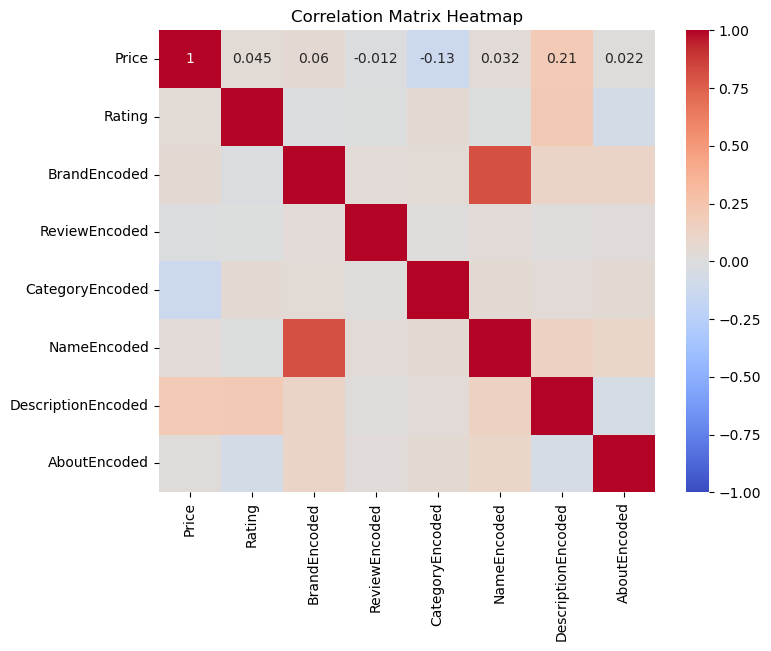

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

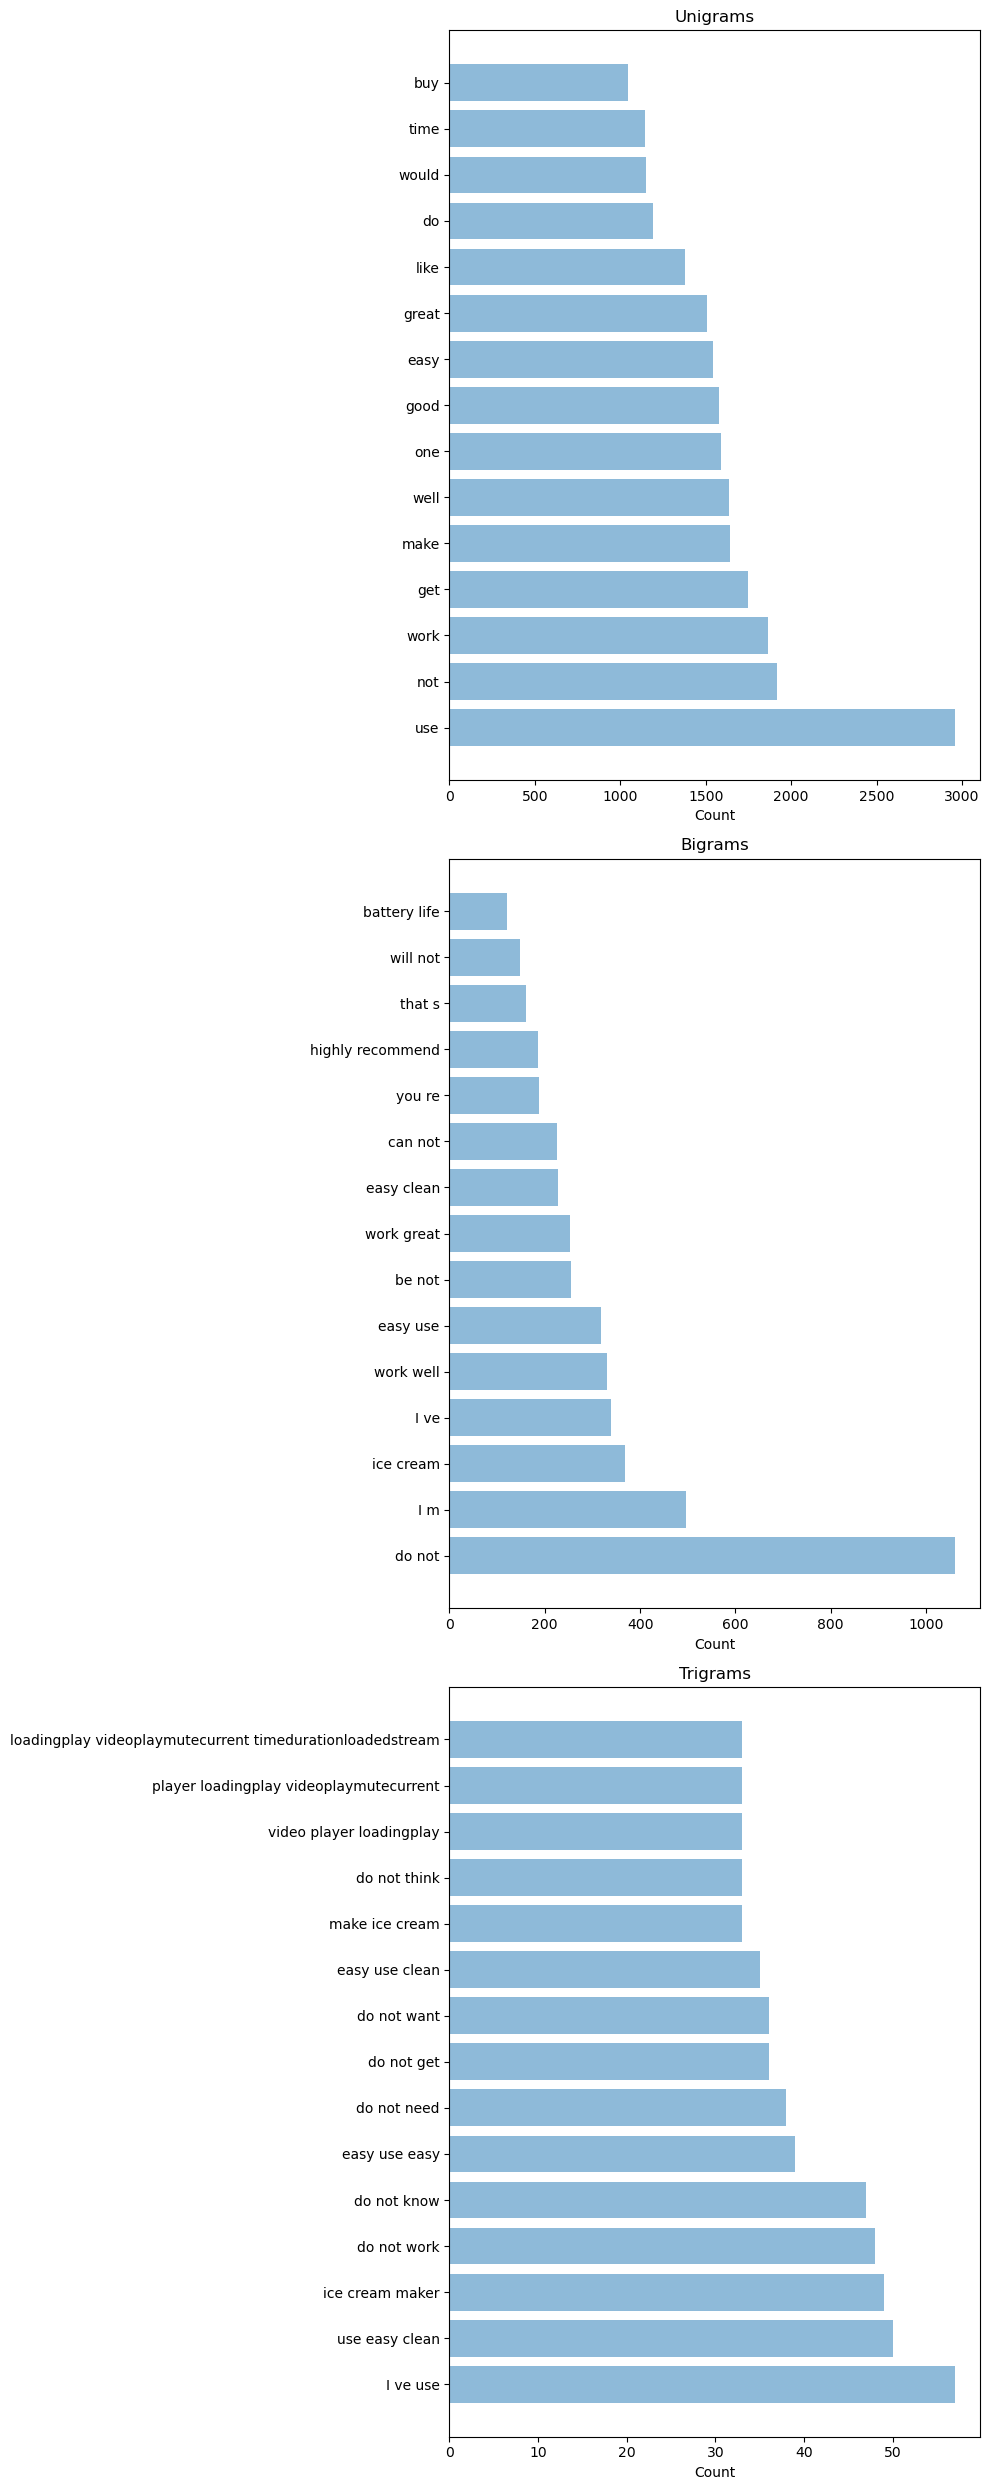

In [26]:
def generate_ngrams(tokens, n):
    ngrams_list = list(ngrams(tokens, n))
    return [" ".join(gram) for gram in ngrams_list]


def generate_grams(col_df, size):
    ngrams_all = []
    for document in col_df:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        ngrams_all.extend(generate_ngrams(tokens, size))

    cnt_ngram = Counter(ngrams_all)
    most_common_ngrams = cnt_ngram.most_common(15)

    temp_df = pd.DataFrame(most_common_ngrams, columns=['words', 'count'])
    temp_df = temp_df.sort_values(by='count', ascending=False)

    return temp_df


def plot_n_grams(col_df):
    unigrams = generate_grams(col_df, 1)
    bigrams = generate_grams(col_df, 2)
    trigrams = generate_grams(col_df, 3)

    # Set plot figure size
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))  # 3 rows, 1 column

    # Plot Unigrams
    ax1.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax1.set_title('Unigrams')
    ax1.set_yticks(np.arange(len(unigrams['words'])))
    ax1.set_yticklabels(unigrams['words'])
    ax1.set_xlabel('Count')

    # Plot Bigrams
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    ax2.set_yticks(np.arange(len(bigrams['words'])))
    ax2.set_yticklabels(bigrams['words'])
    ax2.set_xlabel('Count')

    # Plot Trigrams
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    ax3.set_yticks(np.arange(len(trigrams['words'])))
    ax3.set_yticklabels(trigrams['words'])
    ax3.set_xlabel('Count')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


plot_n_grams(df['Review'])


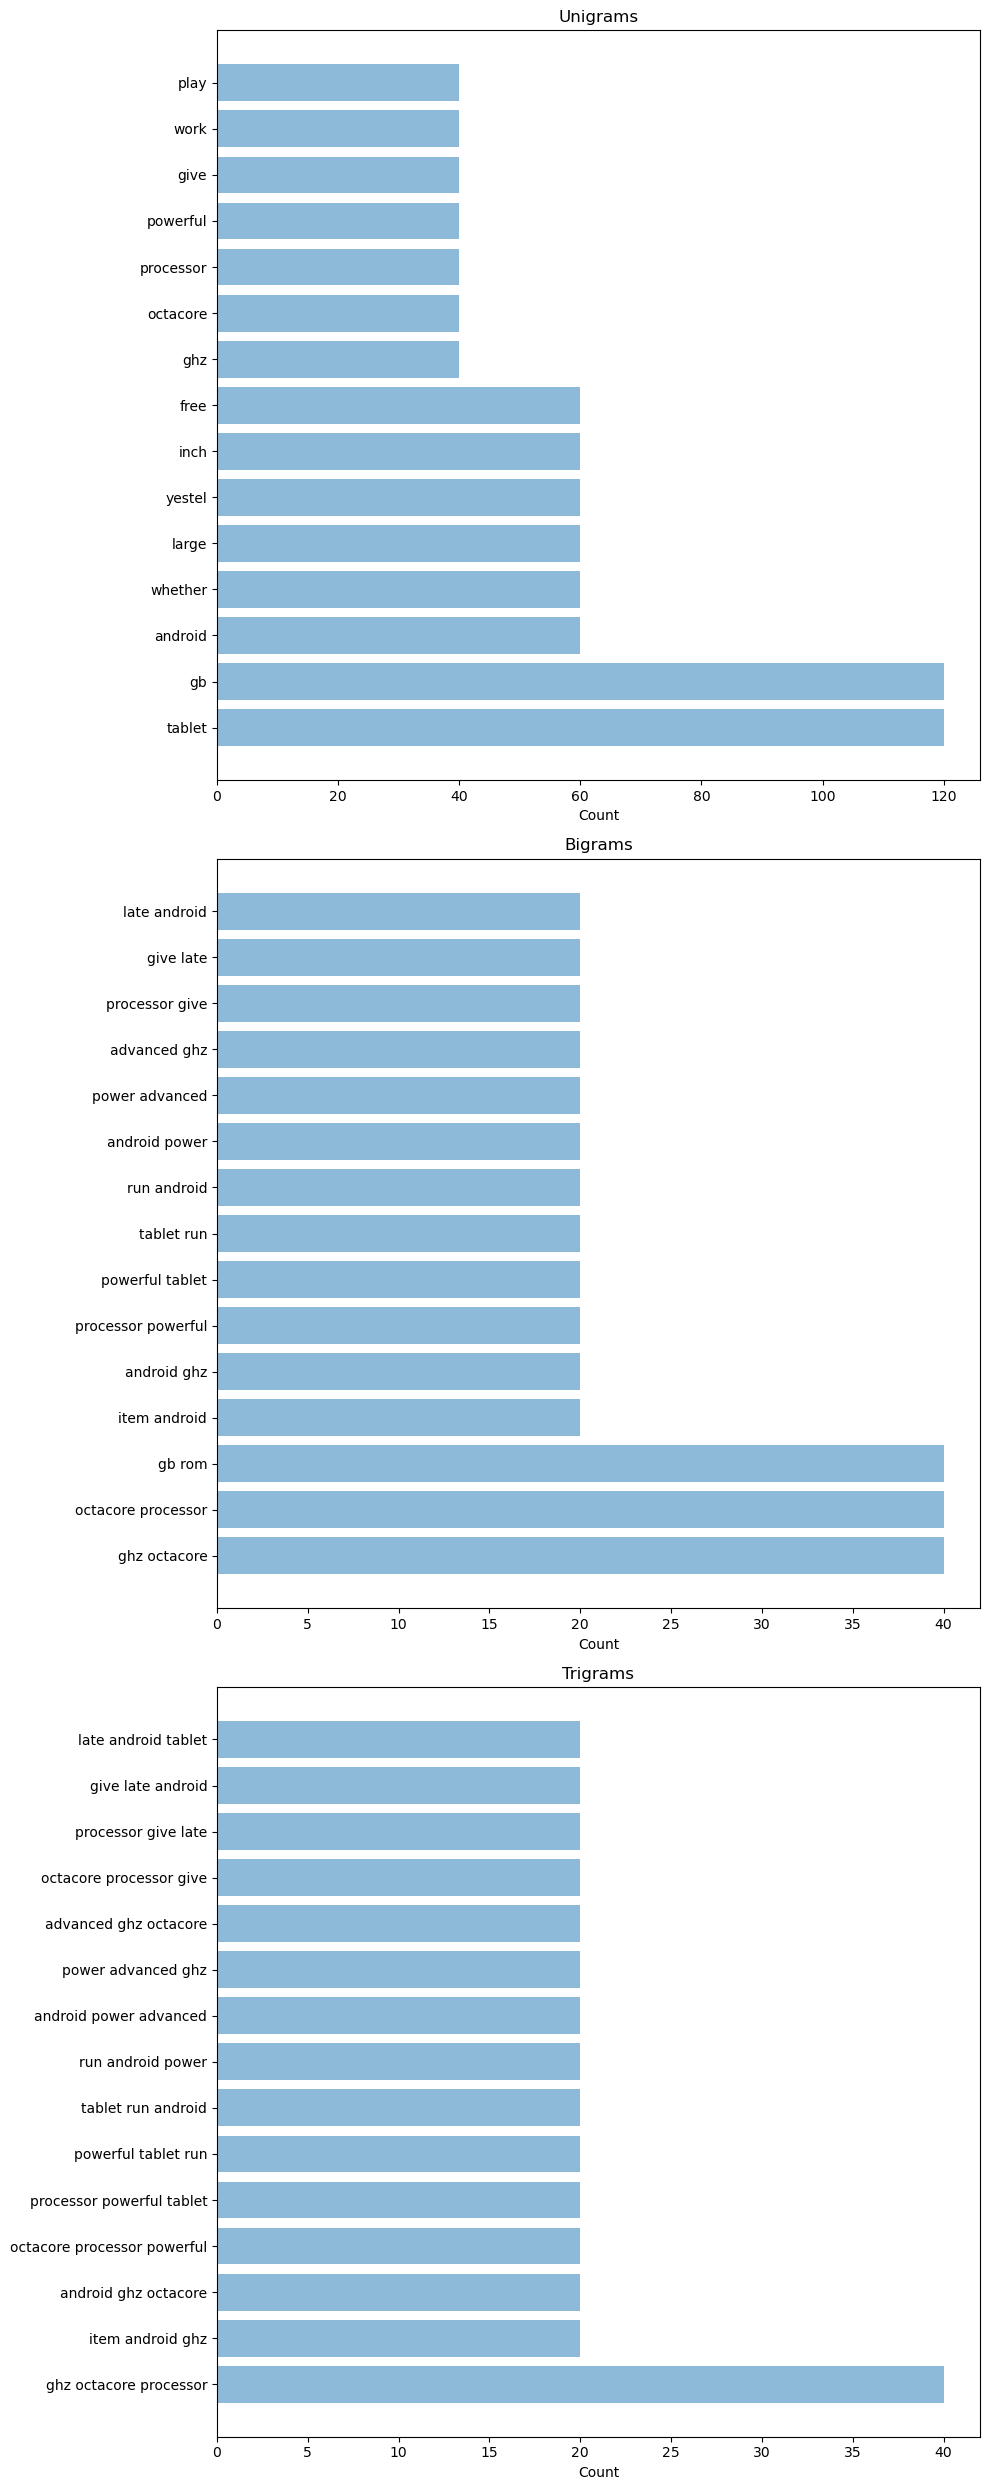

In [27]:
plot_n_grams(df['About'])

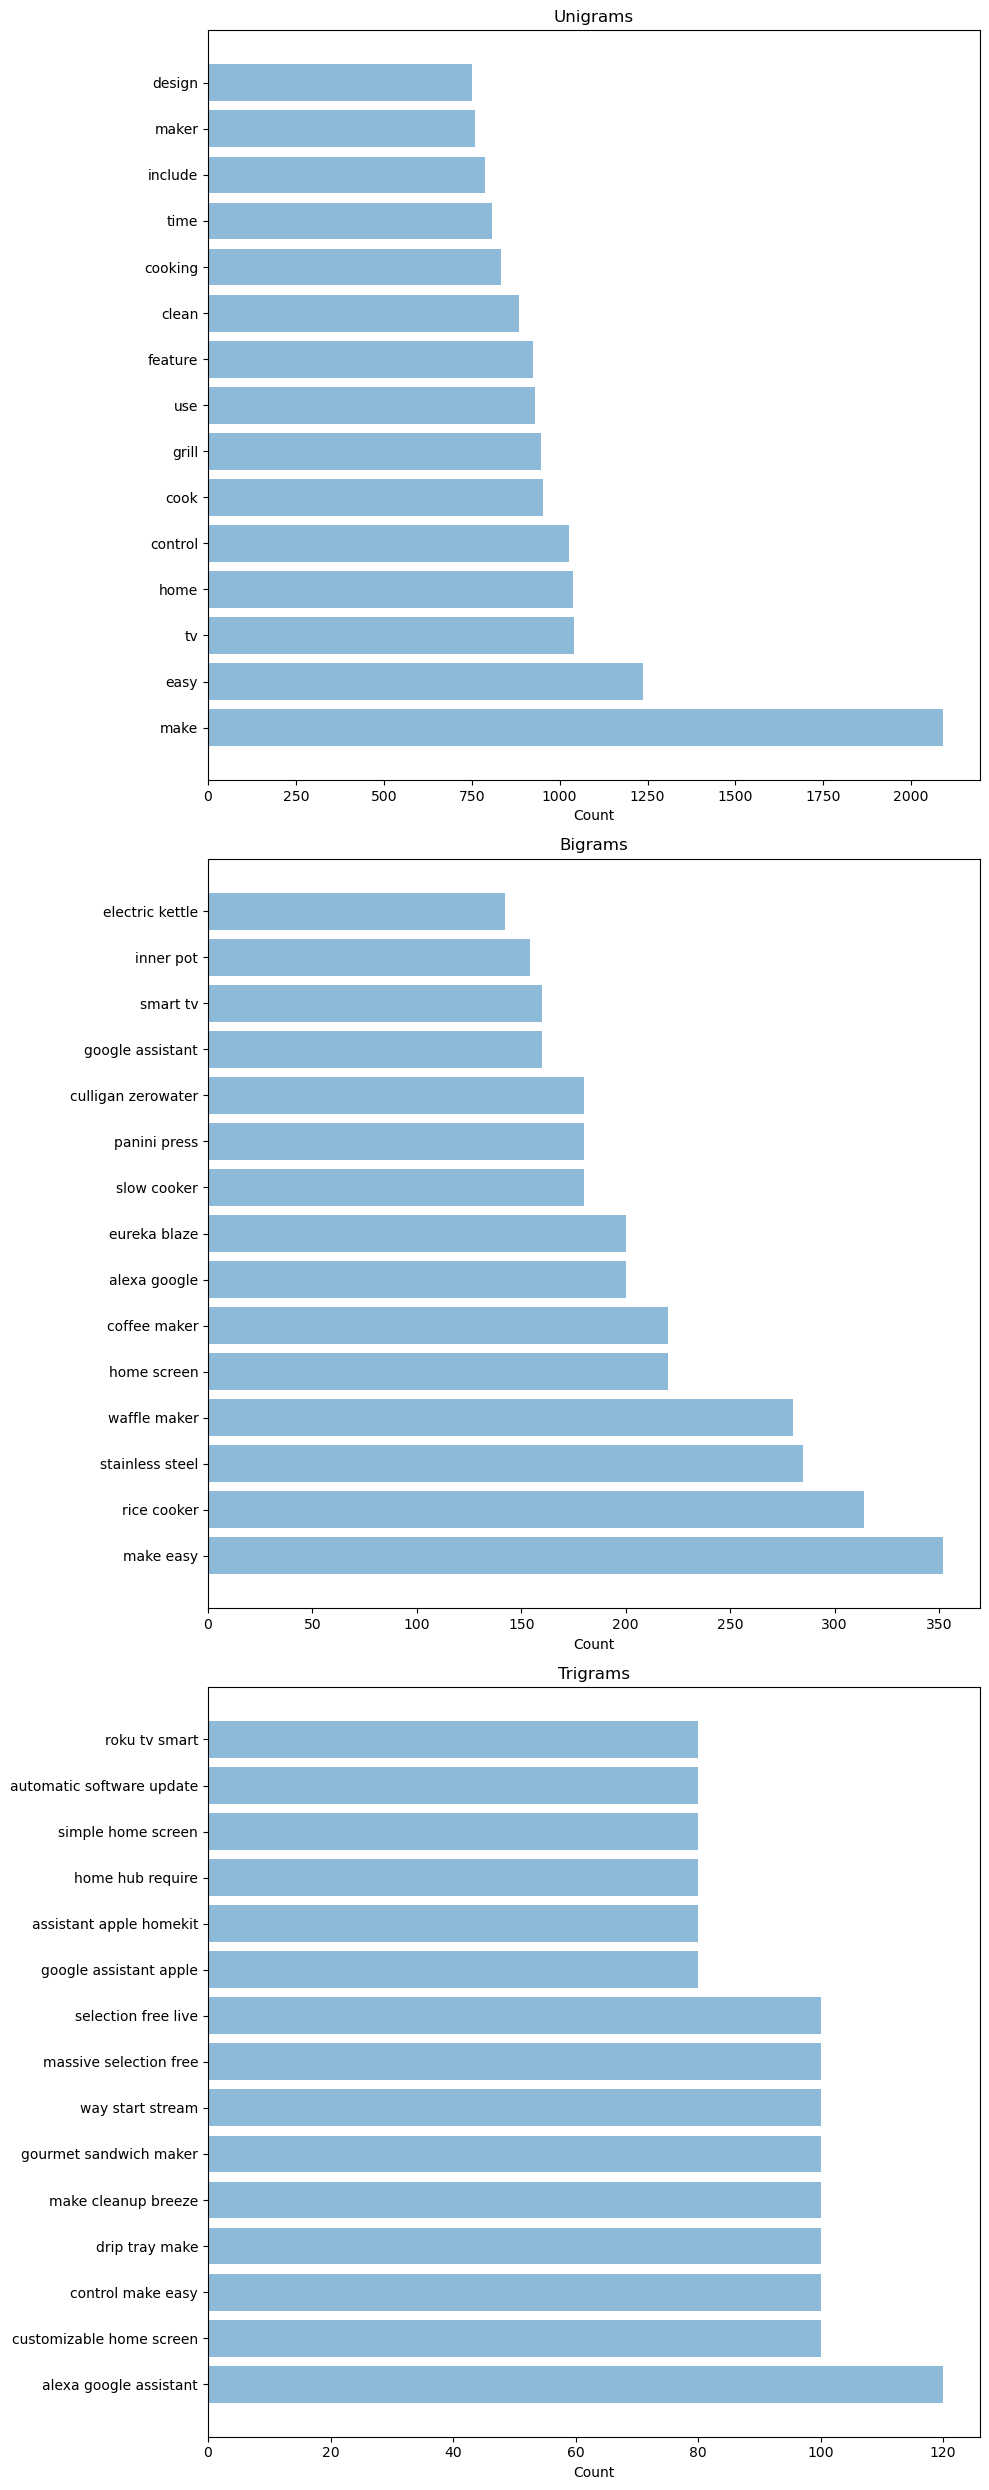

In [28]:
plot_n_grams(df['Description'])

World Cloud

In [29]:
def generate_word_cloud(category: str, type: str):
    if type == 'tf_idf':
        X_category_tfidf = text_wrangler.tf_idf(df[category])

        X_category_tfidf_df = pd.DataFrame(
            X_category_tfidf.toarray(), columns=text_wrangler.tf_idf_.get_feature_names_out()
        )

        # Calculate the sum of TF-IDF scores for each word
        tfidf_word_frequency = X_category_tfidf_df.sum(axis=0).sort_values(ascending=False)

        # Plot word cloud for TF-IDF
        text_wrangler.plot_word_cloud(tfidf_word_frequency, f'{category} Word Cloud using TF-IDF')

        df1 = pd.DataFrame(tfidf_word_frequency, columns=['narrative', 'count'])
        df1.groupby('narrative').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                                  title='Top 20 words in narrative before removing stop words')

    elif type == 'bag_of_words':
        X_category_bow = text_wrangler.bag_of_words(df[category])

        X_category_bow_df = pd.DataFrame(X_category_bow.toarray(), columns=text_wrangler.count.get_feature_names_out())

        # Calculate the sum of word counts for each word
        bow_word_frequency = X_category_bow_df.sum(axis=0).sort_values(ascending=False)

        # Plot word cloud for Bag of Words
        text_wrangler.plot_word_cloud(bow_word_frequency, f'{category} Word Cloud for Bag of Words')

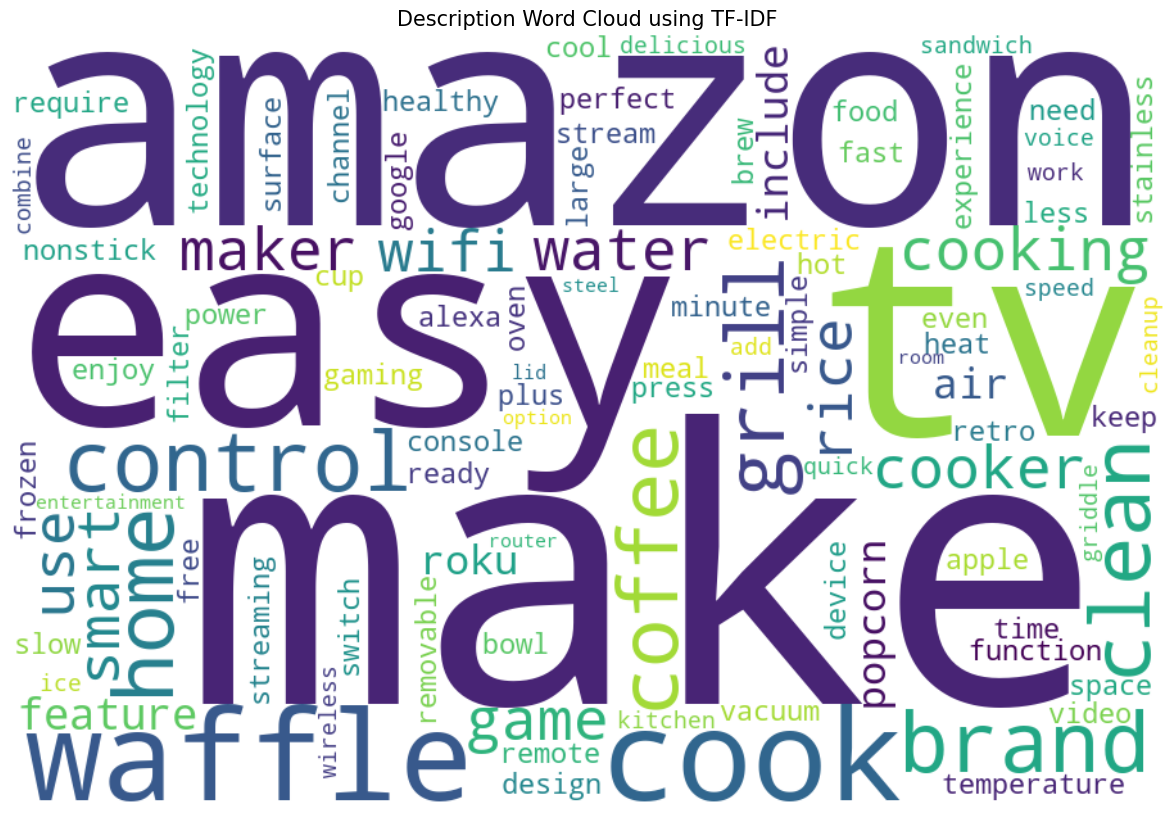

ValueError: Shape of passed values is (2135, 1), indices imply (2135, 2)

In [30]:
# Fit and transform the 'Description' columns using tf_idf

generate_word_cloud(category='Description', type='tf_idf')

In [ ]:
# Fit and transform the 'About' columns using tf_idf

generate_word_cloud(category='About', type='tf_idf')

In [ ]:
# Fit and transform the 'Review' columns using tf_idf

generate_word_cloud(category='Review', type='tf_idf')

In [ ]:
# Fit and transform the 'Description' columns using bag of words

generate_word_cloud(category='Description', type='tf_idf')

In [ ]:
# Fit and transform the 'About' columns using bag of words

generate_word_cloud(category='About', type='tf_idf')

In [ ]:
# Fit and transform the 'Review' columns using bag of words

generate_word_cloud(category='Review', type='tf_idf')

Sentiment Analysis

In [ ]:
class TextSentimentAnalysis:
    def __init__(self):
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        # Using compound score as a single sentiment score
        return self.sid.polarity_scores(text)['compound']

    @staticmethod
    def get_sentiment_via_textblob(text: str) -> float:
        """
            method to get sentiment scores
            returns polarity score as sentiment value
        """
        blob = TextBlob(text)
        return blob.sentiment.polarity


In [ ]:
text_sentiment_analysis = TextSentimentAnalysis()

In [ ]:
# Applying sentiment
df['ReviewSentiment'] = df['Review'].apply([text_sentiment_analysis.get_sentiment_via_vader])
df['DescriptionSentiment'] = df['Description'].apply(text_sentiment_analysis.get_sentiment_via_vader)
df['AboutSentiment'] = df['About'].apply(text_sentiment_analysis.get_sentiment_via_vader)

df.head()

In [ ]:
# Apply sentiment analysis to 'Description', About and 'Review' columns
# data['DescriptionSentiment_2'] = data['Description'].apply(get_sentiment_via_textblob)
# data['ReviewSentiment_2'] = data['Review'].apply(get_sentiment_via_textblob)
# data['AboutSentiment_2'] = data['About'].apply(get_sentiment_via_textblob)

In [ ]:
regression_model_name = "regression-model.pkl"


class RegressionModel:
    def __init__(self, vectorizer='tfidf', ngram_end_range=1):
        if vectorizer == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=(1, ngram_end_range))
        elif vectorizer == 'bow':
            self.vectorizer = CountVectorizer(ngram_range=(1, ngram_end_range))
        else:
            raise ValueError("Invalid vectorizer. Choose 'tfidf' or 'bow'.")

        self.sid = SentimentIntensityAnalyzer()
        self.model = RandomForestRegressor(n_estimators=5, random_state=42)
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('regressor', self.model)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return {
            'r2': r2_score(y, y_pred),
            'mae': mean_absolute_error(y, y_pred),
            'mse': mean_squared_error(y, y_pred)
        }

    def cross_validate(self, X, y, cv=5):
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        r2_scores = cross_val_score(self.pipeline, X, y, cv=kf, scoring='r2')
        mse_scores = cross_val_score(self.pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
        mae_scores = cross_val_score(self.pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
        return {
            'r2': r2_scores.mean(),
            'mse': -mse_scores.mean(),
            'mae': -mae_scores.mean()
        }

    def save_model(self):
        # dump(self.pipeline, regression_model_name)
        save_regressor = open(regression_model_name, "wb")
        pickle.dump(self.pipeline, save_regressor)
        save_regressor.close()

    def load_saved_model(self):
        # self.pipeline = load(regression_model_name)
        regressor_f = open(regression_model_name, "rb")
        self.pipeline = pickle.load(regressor_f)
        regressor_f.close()

    def get_sentiment(self, review: str) -> float:
        return self.sid.polarity_scores(review)['compound']

    def suggest_good_product(self, df, category):
        category_df = df[df['Category'] == category]
        category_df['sentiment'] = category_df['Review'].apply(self.get_sentiment)
        return category_df.loc[category_df['sentiment'].idxmax()]

    def predict_ideal_price(self, df, category):
        category_df = df[df['Category'] == category]
        X_cat = category_df['Text']
        y_cat_pred = self.predict(X_cat)
        return np.mean(y_cat_pred)


In [ ]:
# Combine all the text data type into a single text feature
df['Text'] = df['Name'] + ' ' + df['Category'] + ' ' + df['Brand'] + ' ' + df['Review']

# Define feature and target variables
X = df['Text']
y = df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define ngram ranges to test
ngram_end_range = [1, 2, 3]
vectorizer_types = ['bow', 'tfidf']

results = []
best_score = float('-inf')

for vectorizer in vectorizer_types:
    for end_range in ngram_end_range:
        print(f"Training model with {vectorizer} vectorizer and ngram_range=(1, {end_range})")
        model = RegressionModel(vectorizer=vectorizer, ngram_end_range=end_range)
        model.fit(X_train, y_train)
        scores = model.score(X_test, y_test)
        # scores = model.cross_validate(X, y, cv=5)
        results.append({
            'Vectorizer': vectorizer,
            'Ngram Range': f'(1, {end_range})',
            'R-squared': scores['r2'],
            'MSE': scores['mse'],
            'MAE': scores['mae']
        })

        if scores['r2'] > best_score:
            best_score = scores['r2']
            model.save_model()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Visualize results
plt.figure(figsize=(14, 6))
sns.barplot(x='Ngram Range', y='R-squared', hue='Vectorizer', data=results_df)
plt.title('R-squared Comparison by Vectorizer and Ngram Range')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='Ngram Range', y='MSE', hue='Vectorizer', data=results_df)
plt.title('Mean Squared Error Comparison by Vectorizer and Ngram Range')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='Ngram Range', y='MAE', hue='Vectorizer', data=results_df)
plt.title('Mean Absolute Error Comparison by Vectorizer and Ngram Range')
plt.show()


In [ ]:
categories = df['Category'].unique()
categories

In [ ]:
# User interaction to predict price for a specific category
category = input("Enter a category: ").lower()

if categories not in categories:
    print('We dont have this category')
else:
    _model = RegressionModel()
    _model.load_saved_model()

    ideal_price = _model.predict_ideal_price(df, category)
    print(f"Ideal price for category {category}: {ideal_price}")


In [ ]:
df.head()

In [ ]:

# Correlation between sentiment scores and price
correlation = df['sentiment'].corr(df['Price'])
print(f"Correlation between sentiment scores and price: {correlation}")

# Visualization of sentiment vs price
sns.scatterplot(x='sentiment', y='Price', data=df)
plt.title('Sentiment vs Price')
plt.xlabel('Sentiment')
plt.ylabel('Price')
plt.show()


stack,